🏛️ Loan Risk Prediction

Given *data about German loans*, let's try to detect **high-risk loans** in the data.

We will use a logistic regression model to make our predictions. 

Data source: https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk

### Importing Libraries

In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [45]:
data = pd.read_csv("german_credit_data.csv")
data

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


### Preprocessing

In [47]:
df = data.copy()

In [48]:
# Drop duplicate id column
df = df.drop('Unnamed: 0', axis=1)
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [49]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [50]:
df['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [51]:
df['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

In [52]:
# Encode missing values as 'none'
for column in ['Saving accounts', 'Checking account']:
    df[column] = df[column].fillna('none')

In [53]:
df.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [54]:
{column: list(df[column].unique()) for column in df.select_dtypes('object').columns}

{'Sex': ['male', 'female'],
 'Housing': ['own', 'free', 'rent'],
 'Saving accounts': ['none', 'little', 'quite rich', 'rich', 'moderate'],
 'Checking account': ['little', 'moderate', 'none', 'rich'],
 'Purpose': ['radio/TV',
  'education',
  'furniture/equipment',
  'car',
  'business',
  'domestic appliances',
  'repairs',
  'vacation/others'],
 'Risk': ['good', 'bad']}

In [55]:
{column: len(df[column].unique()) for column in df.select_dtypes('object').columns}

{'Sex': 2,
 'Housing': 3,
 'Saving accounts': 5,
 'Checking account': 4,
 'Purpose': 8,
 'Risk': 2}

In [56]:
def binary_encode(df, columns_with_positive_values):
    df = df.copy()
    for column, positive_value in columns_with_positive_values:
        df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

In [57]:
df['Risk'].value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

In [58]:
# Binary encode Sex and Risk columns
df = binary_encode(df, [("Sex", "male"), ("Risk", "bad")])

In [59]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,own,none,little,1169,6,radio/TV,0
1,22,0,2,own,little,moderate,5951,48,radio/TV,1
2,49,1,1,own,little,none,2096,12,education,0
3,45,1,2,free,little,little,7882,42,furniture/equipment,0
4,53,1,2,free,little,little,4870,24,car,1
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,own,little,none,1736,12,furniture/equipment,0
996,40,1,3,own,little,little,3857,30,car,0
997,38,1,2,own,little,none,804,12,radio/TV,0
998,23,1,2,free,little,little,1845,45,radio/TV,1


In [61]:
def ordinal_encode(df, columns_with_orderings):
    df = df.copy()
    for column, ordering in columns_with_orderings:
        df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

In [62]:
# Ordinal encode the Savings accounts column and Checking account columns
df = ordinal_encode(
    df,
    columns_with_orderings=[
        ('Saving accounts', ['none', 'little', 'moderate', 'rich', 'quite rich']),
        ('Checking account', ['none', 'little', 'moderate', 'rich'])
    ]
)

In [63]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,own,0,1,1169,6,radio/TV,0
1,22,0,2,own,1,2,5951,48,radio/TV,1
2,49,1,1,own,1,0,2096,12,education,0
3,45,1,2,free,1,1,7882,42,furniture/equipment,0
4,53,1,2,free,1,1,4870,24,car,1
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,own,1,0,1736,12,furniture/equipment,0
996,40,1,3,own,1,1,3857,30,car,0
997,38,1,2,own,1,0,804,12,radio/TV,0
998,23,1,2,free,1,1,1845,45,radio/TV,1


In [66]:
{column: list(df[column].unique()) for column in df.select_dtypes('object').columns}

{'Housing': ['own', 'free', 'rent'],
 'Purpose': ['radio/TV',
  'education',
  'furniture/equipment',
  'car',
  'business',
  'domestic appliances',
  'repairs',
  'vacation/others']}

In [67]:
def onehot_encode(df, columns_with_prefixes):
    df = df.copy()
    for col, prefix in columns_with_prefixes:
        dummies = pd.get_dummies(df[col], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(col, axis=1)
    return df

In [68]:
# One Hot Encode the Housing and Purpose columns
df = onehot_encode(
    df,
    columns_with_prefixes = [
        ('Housing', 'H'),
        ('Purpose', 'P')
    ]
)

In [69]:
df

,Age,Sex,Job,Saving accounts,Checking account,Credit amount,Duration,Risk,H_free,H_own,H_rent,P_business,P_car,P_domestic appliances,P_education,P_furniture/equipment,P_radio/TV,P_repairs,P_vacation/others
0,67,1,2,0,1,1169,6,0,False,True,False,False,False,False,False,False,True,False,False
1,22,0,2,1,2,5951,48,1,False,True,False,False,False,False,False,False,True,False,False
2,49,1,1,1,0,2096,12,0,False,True,False,False,False,False,True,False,False,False,False
3,45,1,2,1,1,7882,42,0,True,False,False,False,False,False,False,True,False,False,False
4,53,1,2,1,1,4870,24,1,True,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,0,1736,12,0,False,True,False,False,False,False,False,True,False,False,False
996,40,1,3,1,1,3857,30,0,False,True,False,False,True,False,False,False,False,False,False
997,38,1,2,1,0,804,12,0,False,True,False,False,False,False,False,False,True,False,False
998,23,1,2,1,1,1845,45,1,True,False,False,False,False,False,False,False,True,False,False


In [70]:
# Split the df into X and y
y = df['Risk'].copy()
X = df.drop('Risk', axis=1).copy()

In [71]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=123)

In [73]:
len(X_train), len(X_test)

(700, 300)

In [74]:
len(y_train), len(y_test)

(700, 300)

In [76]:
# Scale X with a standard scaler 
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [77]:
X_train

,Age,Sex,Job,Saving accounts,Checking account,Credit amount,Duration,H_free,H_own,H_rent,P_business,P_car,P_domestic appliances,P_education,P_furniture/equipment,P_radio/TV,P_repairs,P_vacation/others
0,-0.313046,0.685994,-1.351022,-0.212662,1.006728,-0.703098,-0.202413,-0.346410,0.634670,-0.468521,-0.330681,-0.699544,-0.114125,-0.252646,-0.46398,1.586691,-0.162459,-0.114125
1,-0.745260,-1.457738,0.174325,-0.212662,-1.027066,-0.748204,-0.727511,-0.346410,0.634670,-0.468521,3.024058,-0.699544,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
2,-0.572375,0.685994,-1.351022,-1.211746,2.023626,-0.628051,-1.427641,-0.346410,0.634670,-0.468521,-0.330681,1.429503,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
3,-0.831703,0.685994,0.174325,-0.212662,-1.027066,0.780723,0.585234,-0.346410,0.634670,-0.468521,3.024058,-0.699544,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
4,1.588695,-1.457738,-2.876370,-0.212662,-1.027066,-0.947679,-1.252609,-0.346410,0.634670,-0.468521,-0.330681,1.429503,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,-0.572375,0.685994,1.699673,-0.212662,-0.010169,1.349210,0.322685,2.886751,-1.575623,-0.468521,-0.330681,1.429503,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
696,-0.140161,0.685994,1.699673,-0.212662,-0.010169,-0.077451,0.322685,2.886751,-1.575623,-0.468521,-0.330681,1.429503,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
697,-0.918146,-1.457738,0.174325,-1.211746,-1.027066,-0.710097,0.147653,-0.346410,-1.575623,2.134375,-0.330681,1.429503,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125
698,0.032725,0.685994,0.174325,-0.212662,-1.027066,-0.609387,-0.727511,-0.346410,0.634670,-0.468521,3.024058,-0.699544,-0.114125,-0.252646,-0.46398,-0.630242,-0.162459,-0.114125


In [78]:
X_test

,Age,Sex,Job,Saving accounts,Checking account,Credit amount,Duration,H_free,H_own,H_rent,P_business,P_car,P_domestic appliances,P_education,P_furniture/equipment,P_radio/TV,P_repairs,P_vacation/others
0,-0.572375,0.685994,0.174325,-0.212662,-0.010169,1.468973,1.372881,-0.34641,0.634670,-0.468521,-0.330681,-0.699544,-0.114125,3.958114,-0.463980,-0.630242,-0.162459,-0.114125
1,-1.263917,0.685994,0.174325,-0.212662,-0.010169,-0.858246,-0.727511,-0.34641,-1.575623,2.134375,-0.330681,-0.699544,-0.114125,3.958114,-0.463980,-0.630242,-0.162459,-0.114125
2,-0.572375,0.685994,-1.351022,-1.211746,1.006728,-0.301813,0.322685,-0.34641,0.634670,-0.468521,-0.330681,-0.699544,-0.114125,-0.252646,2.155264,-0.630242,-0.162459,-0.114125
3,-1.350359,-1.457738,0.174325,-0.212662,-0.010169,-0.416133,-0.202413,-0.34641,-1.575623,2.134375,-0.330681,-0.699544,-0.114125,-0.252646,2.155264,-0.630242,-0.162459,-0.114125
4,-0.053718,0.685994,0.174325,-1.211746,1.006728,-0.148220,-0.464962,-0.34641,0.634670,-0.468521,-0.330681,-0.699544,-0.114125,-0.252646,-0.463980,1.586691,-0.162459,-0.114125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-0.658817,-1.457738,0.174325,0.786422,1.006728,-0.323199,-0.202413,-0.34641,0.634670,-0.468521,-0.330681,1.429503,-0.114125,-0.252646,-0.463980,-0.630242,-0.162459,-0.114125
296,-0.399489,0.685994,0.174325,-0.212662,-1.027066,-0.129945,-0.202413,-0.34641,0.634670,-0.468521,-0.330681,1.429503,-0.114125,-0.252646,-0.463980,-0.630242,-0.162459,-0.114125
297,-0.745260,-1.457738,0.174325,-0.212662,-0.010169,-1.075608,-1.252609,-0.34641,0.634670,-0.468521,-0.330681,-0.699544,8.762293,-0.252646,-0.463980,-0.630242,-0.162459,-0.114125
298,0.032725,0.685994,0.174325,-0.212662,-0.010169,-0.120613,-0.990060,-0.34641,-1.575623,2.134375,-0.330681,1.429503,-0.114125,-0.252646,-0.463980,-0.630242,-0.162459,-0.114125


### Training

In [81]:
y_train.value_counts()

Risk
0    500
1    200
Name: count, dtype: int64

In [136]:
model = LogisticRegression(
    class_weight={
        0:1,
        1:1.5
    }
)

model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 1.5})

### Results

In [137]:
model.score(X_test, y_test)

0.66

In [138]:
model.predict(X_test)

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [139]:
list(map(lambda x: x[1],
    (model.predict_proba(X_test) >= 0.5).astype(np.int64)
   ))

[np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.in

In [140]:
def evaluate_model(model, X_test, y_test, classification_threshold=0.5):

    y_true = np.array(y_test)
    
    y_pred = (model.predict_proba(X_test) >= classification_threshold).astype(np.int64)
    y_pred = list(map(
        lambda x: x[1],
        y_pred
    ))

    print("Test Accuracy: {:.2f}%".format(accuracy_score(y_true, y_pred)*100))

    cm = confusion_matrix(y_true, y_pred)

    clr = classification_report(y_true, y_pred, target_names=['Not Risky', 'Risky'])

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, vmin=0 ,fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(np.arange(2) + 0.5, ['Not Risky', 'Risky'])
    plt.yticks(np.arange(2) + 0.5, ['Not Risky', 'Risky'])
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n--------------------------\n", clr)

Test Accuracy: 66.00%


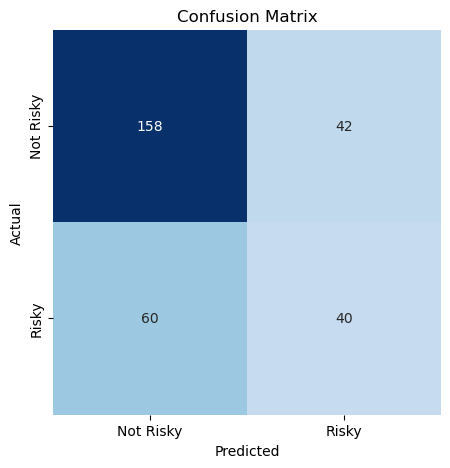

Classification Report:
--------------------------
               precision    recall  f1-score   support

   Not Risky       0.72      0.79      0.76       200
       Risky       0.49      0.40      0.44       100

    accuracy                           0.66       300
   macro avg       0.61      0.59      0.60       300
weighted avg       0.65      0.66      0.65       300



In [141]:
evaluate_model(model, X_test, y_test, 0.5)